In [1]:
import numpy as np
import pandas as pd
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import h5py
from PIL import Image, ImageDraw
import nrrd
import os

from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
import platform
if platform.system() == 'Windows':
    basepath = r'C:\Users\jenniferwh\Dropbox (Allen Institute)\Mesoscale Connectome Papers in Progress/2019 DMN'
elif platform.system() == 'Darwin':
    basepath = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN'
savepath = os.path.join(basepath, 'data_files')

# Load reference space

In [3]:
mcc = MouseConnectivityCache(manifest_file='../connectivity/mouse_connectivity_manifest.json',
                             resolution=10)
rsp = mcc.get_reference_space()
rsp.remove_unassigned();

In [4]:
name_map = rsp.structure_tree.get_name_map()

In [5]:
avg,meta = mcc.get_template_volume()

In [6]:
avg.shape

(1320, 800, 1140)

# Load data

In [7]:
structure_tree = mcc.get_structure_tree()
iso = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
ctx_exps = pd.DataFrame(mcc.get_experiments(cre=False, 
                                       injection_structure_ids=[iso['id']]))

In [8]:
cre_exps = pd.DataFrame(mcc.get_experiments(cre=['Emx1-IRES-Cre','Rbp4-Cre_KL100'],
                                      injection_structure_ids = [iso['id']]))
ctx_exps = pd.concat([ctx_exps, cre_exps])
Fig4_expts = [126861679, 146593590, 139426984, 100148503, 112229103, 307295727, 112595376,
              112423392, 112306316, 157711748, 158435116, 307593747, 100141219, 100141599,
              112424813, 478376197, 593018150, 526783054, 518742338, 125833030, 480994108,
              287769286, 478491090, 266250195, 584895127, 646525997, 576341623, 479755622,
              571100135, 575782182, 524667618, 478376911, 156741826, 159753308, 121510421,
              646525156, 479673887, 482580380, 496576666, 263106036, 562674923, 167902586]
ctx_exps = ctx_exps[ctx_exps['id'].isin(Fig4_expts)]
print(len(ctx_exps))

42


In [9]:
subset = ctx_exps[['id', 'injection_x','injection_y','injection_z']]
print(len(subset))

42


In [10]:
# Put all injections in left hemisphere but keep track of where they started
lr = []
zcoords = []
for ix,row in subset.iterrows():
    if row['injection_z'] > 5700:
        lr.append('right')
        zcoords.append(row['injection_z'] - 5700)
    else:
        lr.append('left')
        zcoords.append(row['injection_z'])

In [11]:
subset['injection_z'] = zcoords
subset['hemisphere'] = lr

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Get cortical map lookup tables

In [12]:
with h5py.File('surface_paths_10.h5') as f:
    path_lookup = f['volume lookup'][()]
    paths = f['paths'][()]

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [13]:
with h5py.File('top.h5') as f:
    top_lookup = f['view lookup'][()]
    top_size = f.attrs['view size']

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [14]:
# This gives us the path indices that point to the side
path_indices = path_lookup.flat[top_lookup[:,1]]

# Now we can subsample the paths
top_paths = paths[path_indices,:]

In [28]:
# Flat map lookup table
flatmap_lookup = h5py.File('flatmap_lookup.h5')
flat_paths = flatmap_lookup['flat_paths'][()]
flat_map = flatmap_lookup['flat_map'][()]
fsize = flatmap_lookup.attrs['size']
flatmap_lookup.close()

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [29]:
path_indeces = path_lookup.flat[flat_paths]
flat_paths = paths[path_indeces,:]

In [15]:
def get_top_centroid_coord(x,y,z,volume_shape,flat_shape, radius):
    point_blank = np.zeros(volume_shape,dtype=np.uint8)
    flat_blank = np.zeros(flat_shape,dtype=np.uint8)    
    point_blank[x-radius:x+radius,y-radius:y+radius,z-radius:z+radius] = 1
#    point_blank = np.flip(point_blank,axis=2)
    
    for streamline in np.arange(top_paths.shape[0]):
        flat_blank.flat[top_lookup[streamline,0]] = \
                max(point_blank.flat[top_paths[streamline,:]])
    
    return np.round(np.mean(np.where(flat_blank),axis=1)).astype(int)

In [32]:
def get_flat_centroid_coord(x,y,z,volume_shape,flat_shape, radius):
    point_blank = np.zeros(volume_shape,dtype=np.uint8)
    flat_blank = np.zeros(flat_shape,dtype=np.uint8)
    
    point_blank[x-radius:x+radius,y-radius:y+radius,z-radius:z+radius] = 1
    point_blank = np.flip(point_blank,axis=2)
    
    for streamline in np.arange(flat_paths.shape[0]):
        flat_blank.flat[flat_map[streamline]] = max(point_blank.flat[flat_paths[streamline,:]])
    
    return np.round(np.mean(np.where(flat_blank),axis=1)).astype(int)

In [17]:
(x,y,z) = (subset.iloc[1,1:4]/10).astype(int)

In [18]:
x,y,z

(527, 165, 48)

In [19]:
top_centroid = get_top_centroid_coord(x,y,z,avg.shape,top_size,1)
if top_centroid[0] < 0:
    j = 1
    while top_centroid[0] < 0:
        j += 1
        if j > 10:
            top_centroid = get_top_centroid_coord(x,y,z,avg.shape,top_size, j*10)
        else:
            top_centroid = get_top_centroid_coord(x,y,z,avg.shape,top_size, j)

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [20]:
top_centroid

array([ 366, 1023])

In [21]:
flatpath = os.path.join(basepath, '_new_figures', 'Figure_4')
import imageio
imb = imageio.imread(os.path.join(flatpath, 'DMN_cortical_projection_boundaries.png'))

In [22]:
imb.shape

(1320, 1140, 4)

<IPython.core.display.Javascript object>


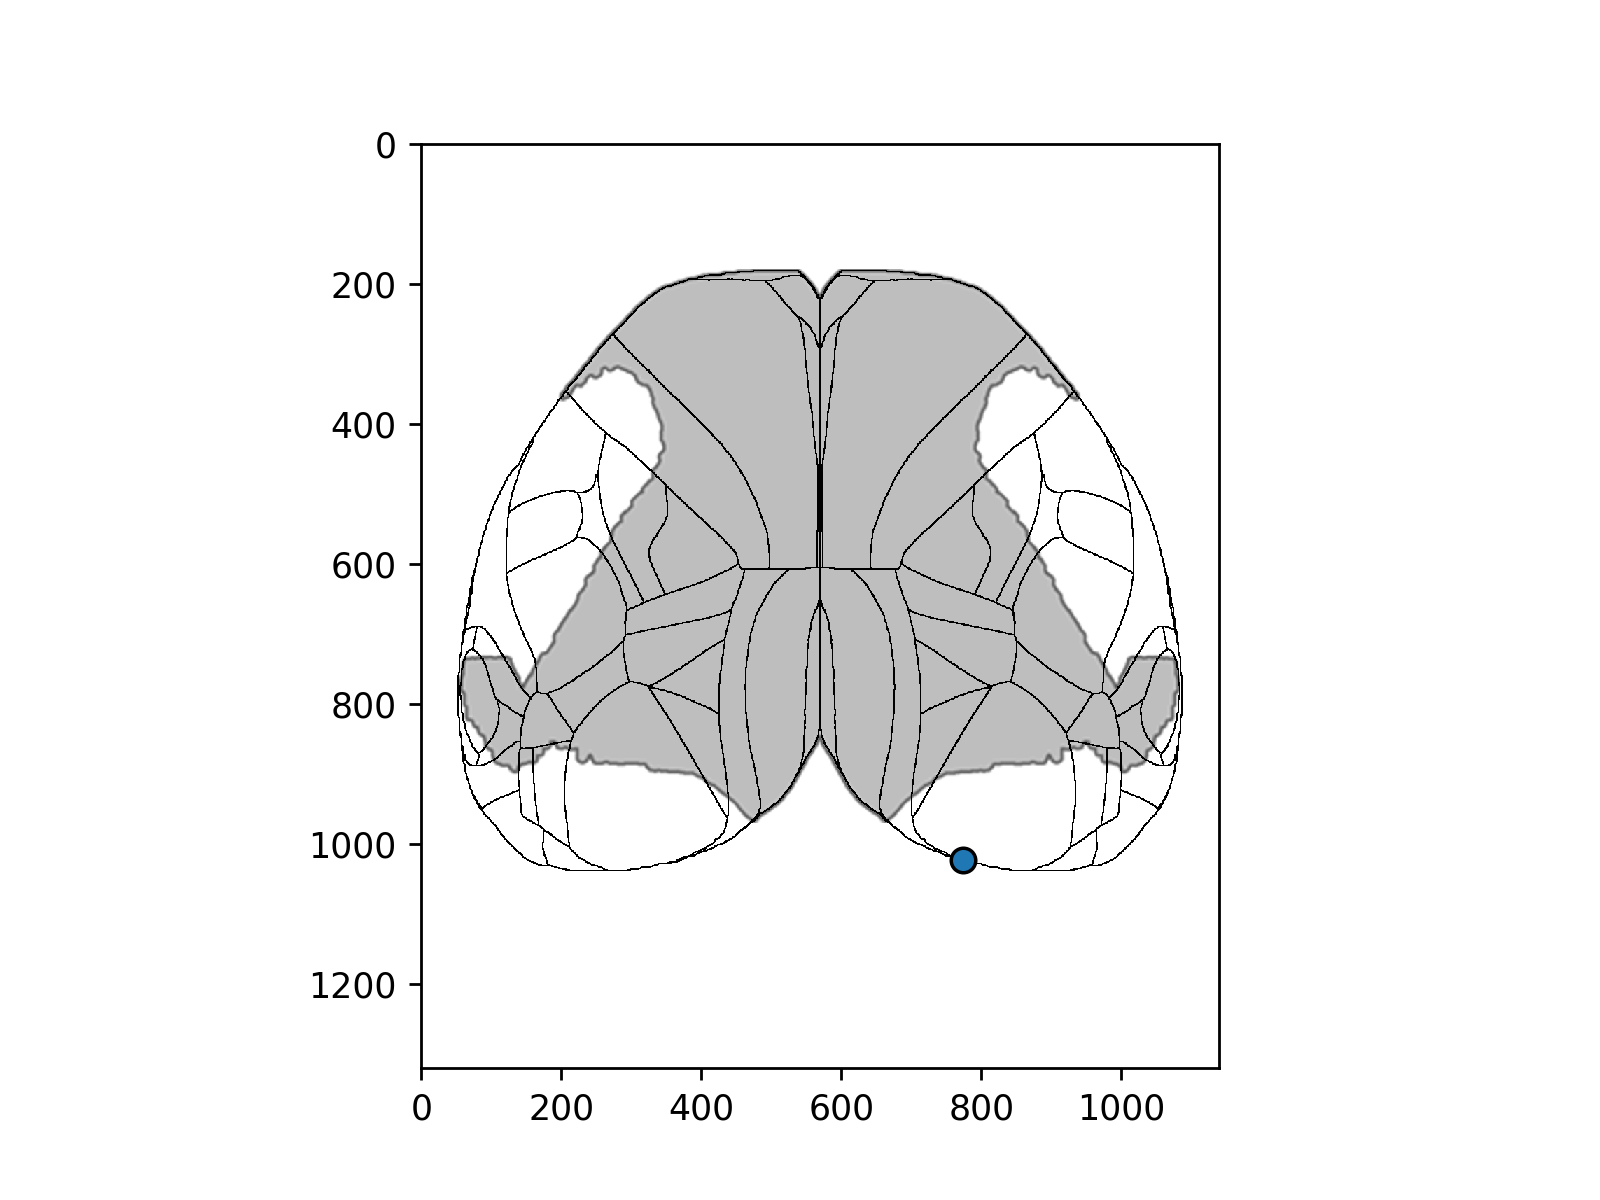

In [25]:
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
cax = ax.scatter(570+(570-top_centroid[0]),
           top_centroid[1],
           edgecolor = 'k',
           s = 50)

In [37]:
flat_centroid = get_flat_centroid_coord(x,y,z,avg.shape,fsize, 1000)

In [38]:
flat_centroid

array([ 611, 1125])

In [41]:
img = Image.new('RGBA',(fsize[1],fsize[0]),(255,255,255,0))
draw = ImageDraw.Draw(img)
draw.ellipse((flat_centroid[0]-3,flat_centroid[1]-3,
              flat_centroid[0]+3,flat_centroid[1]+3),
             fill='black')
img.show()

In [42]:
centroids = []
for i,row in subset.iterrows():
    x,y,z = (row[['injection_x','injection_y','injection_z']]/10).astype(int)
    top_centroid = get_top_centroid_coord(x,y,z,avg.shape,top_size, 1)
    if top_centroid[0] < 0:
        j = 1
        while top_centroid[0] < 0:
            j += 1
            if j > 10:
                top_centroid = get_top_centroid_coord(x,y,z,avg.shape,top_size, j*10)
            else:
                top_centroid = get_top_centroid_coord(x,y,z,avg.shape,top_size, j)
    flat_centroid = get_flat_centroid_coord(x,y,z,avg.shape,fsize, 1)
    if flat_centroid[0] < 0:
        j = 1
        while flat_centroid[0] < 0:
            j += 1
            if j > 10:
                flat_centroid = get_flat_centroid_coord(x,y,z,avg.shape,fsize, j*10)
            else:
                flat_centroid = get_flat_centroid_coord(x,y,z,avg.shape,fsize, j)
    centroids.append({'id':row['id'],
                      'top_x':top_centroid[0],
                      'top_y':top_centroid[1],
                     'flat_x': flat_centroid[0],
                     'flat_y': flat_centroid[1]})   
cent_df = pd.DataFrame(centroids)

KeyboardInterrupt: 

In [43]:
centroids

[{'id': 126861679, 'top_x': 187, 'top_y': 734, 'flat_x': 749, 'flat_y': 188},
 {'id': 146593590, 'top_x': 366, 'top_y': 1023, 'flat_x': 511, 'flat_y': 1226},
 {'id': 139426984, 'top_x': 354, 'top_y': 1026, 'flat_x': 577, 'flat_y': 1269},
 {'id': 100148503, 'top_x': 185, 'top_y': 742, 'flat_x': 754, 'flat_y': 190},
 {'id': 112229103, 'top_x': 566, 'top_y': 283, 'flat_x': 844, 'flat_y': 208},
 {'id': 307295727, 'top_x': 305, 'top_y': 930, 'flat_x': 1078, 'flat_y': 999},
 {'id': 112595376, 'top_x': 159, 'top_y': 833, 'flat_x': 825, 'flat_y': 113},
 {'id': 112423392, 'top_x': 315, 'top_y': 1026, 'flat_x': 373, 'flat_y': 1116},
 {'id': 112306316, 'top_x': 223, 'top_y': 361, 'flat_x': 332, 'flat_y': 1099},
 {'id': 157711748, 'top_x': 272, 'top_y': 1035, 'flat_x': 356, 'flat_y': 1112},
 {'id': 158435116, 'top_x': 200, 'top_y': 599, 'flat_x': 370, 'flat_y': 754},
 {'id': 307593747, 'top_x': 197, 'top_y': 909, 'flat_x': 635, 'flat_y': 207},
 {'id': 100141219, 'top_x': 240, 'top_y': 877, 'flat_x

In [44]:
path = r'/Users/jenniferwh/Desktop/centroids'

In [48]:
import json
for centroid in centroids:
    for key in centroid:
        centroid[key] = float(centroid[key])
    with open(os.path.join(path, 
                           '{}.json'.format(centroid['id'])), 'w') as outfile:
        json.dump(centroid, outfile, sort_keys = False, indent = 4)

In [ ]:
img = Image.new('RGBA',(fsize[1],fsize[0]),(255,255,255,0))
draw = ImageDraw.Draw(img)
for i,row in cent_df.iterrows():
    centroid = row[['flat_x','flat_y']]


    draw.ellipse((centroid[0]-3,centroid[1]-3,centroid[0]+3,centroid[1]+3),fill='black')

In [21]:
len(cent_df)

277

In [22]:
len(subset)

277

centroids = []
for i,row in subset.iterrows():
    x,y,z = (row[['injection_x','injection_y','injection_z']]/10).astype(int)
    top_centroid = get_top_centroid_coord(x,y,z,avg.shape,top_size)
    flat_centroid = get_flat_centroid_coord(x,y,z,avg.shape,fsize)
    centroids.append({'ID':row['id'],'top_x':top_centroid[0],
                      'top_y':top_centroid[1],
                      'flat_x':flat_centroid[0],
                      'flat_y':flat_centroid[1]})   
cent_df = pd.DataFrame(centroids)

In [23]:
subset = subset.merge(cent_df[['id', 'top_x', 'top_y', 'flat_x', 'flat_y']], 
                      on = 'id', how = 'left')

In [24]:
len(subset[subset['top_x'] < 0])

0

In [25]:
len(subset[subset['top_x'].isnull()])

0

In [26]:
wt_meta = pd.read_csv(os.path.join(savepath, 'wt_cre_ctx_injections_DMN_and_core_projections_coefficients.csv'))

In [27]:
len(wt_meta)

277

In [28]:
wt_meta = wt_meta.merge(subset[['id', 'top_x', 'top_y']], on='id', how = 'left')

In [29]:
wt_meta.to_csv(os.path.join(savepath, 
                            'wt_cre_ctx_injections_DMN_and_core_projections_coefficients_flat_coords.csv'),
              index = False)

# Fix missing values

In [30]:
def get_top_centroid_coord(x,y,z,volume_shape,flat_shape, radius):
    point_blank = np.zeros(volume_shape,dtype=np.uint8)
    flat_blank = np.zeros(flat_shape,dtype=np.uint8)
    
    point_blank[x-radius:x+(radius*2),y-radius:y+(radius*2),z-radius:z+(radius*2)] = 1
    
    for streamline in np.arange(top_paths.shape[0]):
        flat_blank.flat[top_lookup[streamline,0]] = \
                max(point_blank.flat[top_paths[streamline,:]])
    
    return np.round(np.mean(np.where(flat_blank),axis=1)).astype(int)

In [61]:
# iterate with increasing window size in function above until all coordinates are filled in
centroids = []
for i,row in subset.iterrows():
    if row['top_x'] < 0:
        x,y,z = (row[['injection_x','injection_y','injection_z']]/10).astype(int)
        top_centroid = get_top_centroid_coord(x,y,z,avg.shape,top_size, i)
        subset.loc[subset['id'] == row['id'], 'top_x'] = top_centroid[0]
        subset.loc[subset['id'] == row['id'], 'top_y'] = top_centroid[1]
print(len(subset[subset['top_x'] < 0]))

114


In [62]:
print(len(subset[subset['top_x'] < 0]))
print(i)

114
276


In [63]:
# iterate with increasing window size in function above until all coordinates are filled in
j=0
for i,row in subset.iterrows():
    while row['top_x'] < 0:
        j+=1
        x,y,z = (row[['injection_x','injection_y','injection_z']]/10).astype(int)
        top_centroid = get_top_centroid_coord(x,y,z,avg.shape,top_size, j*100)
        subset.loc[subset['id'] == row['id'], 'top_x'] = top_centroid[0]
        subset.loc[subset['id'] == row['id'], 'top_y'] = top_centroid[1]

In [64]:
print(len(subset[subset['top_x'] < 0]))
print(j)

0
128


In [66]:
subset.tail()

,id,injection_x,injection_y,injection_z,top_x,top_y
272,598604288,3510,2210,7700,346,331
273,554421791,8470,2080,1810,335,633
274,479756361,9040,1450,3560,335,633
275,296048512,3660,4850,8700,335,633
276,503069254,8690,1440,3090,335,633


In [39]:
wt_meta.head(1)

,id,injection structure,injection dmn fraction,projection dmn fraction,distance coefficient,DMN coefficient,DMN t values,DMN p values,injection core fraction,projection core fraction,core distance coefficient,DMN core coefficient,core t values,core p values
0,307297141,VISp,0.0,0.126831,-0.137688,0.180713,[-239.0178642 7.08477213 -63.88990698],[0.0000000e+00 1.4001496e-12 0.0000000e+00],0.0,0.076321,-0.137798,-0.004175,[-2.38724601e+02 -1.55272840e-01 -6.18889461e+01],[0. 0.87660648 0. ]


In [40]:
img = Image.new('RGBA',(fsize[1],fsize[0]),(255,255,255,0))
draw = ImageDraw.Draw(img)
for i,row in cent_df.iterrows():
    centroid = row[['flat_x','flat_y']]


    draw.ellipse((centroid[0]-3,centroid[1]-3,centroid[0]+3,centroid[1]+3),fill='black')
#     img.save('./new_results_for_julie/{}f.png'.format(i))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in long_scalars
  import sys


In [41]:
img.save('./flat_map_results.png')

In [42]:
img = Image.new('RGBA',(top_size[0],top_size[1]),(255,255,255,0))
draw = ImageDraw.Draw(img)
for i,row in cent_df.iterrows():
    centroid = row[['top_x','top_y']]


    draw.ellipse((centroid[0]-3,centroid[1]-3,centroid[0]+3,centroid[1]+3),fill='black')
#     img.save('./new_results_for_julie/{}.png'.format(i))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in long_scalars
  import sys


In [43]:
img.save('./top_view_results.png')

In [45]:
cent_df.to_json('./top_flat_centroids.json')

# Add labels

In [177]:
from PIL import ImageFont

In [196]:
font = ImageFont.truetype("arial",size=15)

In [201]:
img = Image.new('RGBA',(fsize[1],fsize[0]),(255,255,255,0))
draw = ImageDraw.Draw(img)
for i,row in cent_df.iterrows():
    centroid = row[['flat_x','flat_y']]


    draw.text((centroid[0]-3,centroid[1]-3,centroid[0]+3,centroid[1]+3),"{}".format(i),fill='blue',font=font)
#     img.save('./new_results_for_julie/{}f.png'.format(i))

In [190]:
img.show()

In [202]:
img.save('./flat_ids.png')

In [199]:
img = Image.new('RGBA',(top_size[0],top_size[1]),(255,255,255,0))
draw = ImageDraw.Draw(img)
for i,row in cent_df.iterrows():
    centroid = row[['top_x','top_y']]


    draw.text((centroid[0]-3,centroid[1]-3,centroid[0]+3,centroid[1]+3),"{}".format(i),fill='blue',font=font)
#     img.save('./new_results_for_julie/{}.png'.format(i))

In [200]:
img.save('./top_ids.png')